# SMS Spam Classification
A simple ML pipeline to classify SMS messages as spam or ham.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## 1. Load Data

In [2]:
df = pd.read_csv('sms+spam+collection/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2. Exploratory Data Analysis

In [3]:
print("Label distribution:")
print(df['label'].value_counts())
print(f"\nSpam percentage: {(df['label'] == 'spam').mean() * 100:.1f}%")

Label distribution:
ham     4825
spam     747
Name: label, dtype: int64

Spam percentage: 13.4%


In [4]:
df['length'] = df['message'].str.len()
df.groupby('label')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


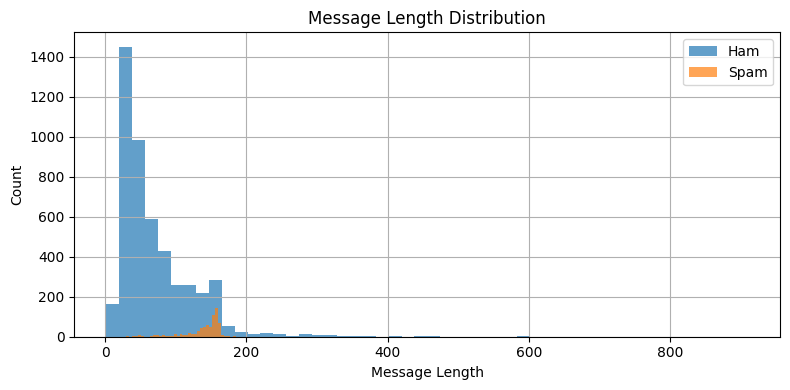

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
df[df['label'] == 'ham']['length'].hist(alpha=0.7, label='Ham', bins=50, ax=ax)
df[df['label'] == 'spam']['length'].hist(alpha=0.7, label='Spam', bins=50, ax=ax)
ax.set_xlabel('Message Length')
ax.set_ylabel('Count')
ax.legend()
ax.set_title('Message Length Distribution')
plt.tight_layout()
plt.show()

## 3. Preprocessing & Train/Test Split

In [6]:
X = df['message']
y = (df['label'] == 'spam').astype(int)  # 1 = spam, 0 = ham

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 4457, Test: 1115


## 4. Model Training & Evaluation

We'll train 4 models:
1. Multinomial Naive Bayes
2. Logistic Regression
3. Support Vector Machine (LinearSVC)
4. Character N-gram Logistic Regression

In [7]:
def evaluate_model(name, model, X_test_vec, y_test):
    """Print classification report and confusion matrix."""
    y_pred = model.predict(X_test_vec)
    print(f"\n{'='*50}")
    print(f"{name}")
    print('='*50)
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Ham', 'Spam'], ax=ax)
    ax.set_title(name)
    plt.tight_layout()
    plt.show()
    return y_pred

In [8]:
# Word-level TF-IDF vectorizer for models 1-3
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### 4.1 Multinomial Naive Bayes


Multinomial Naive Bayes
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



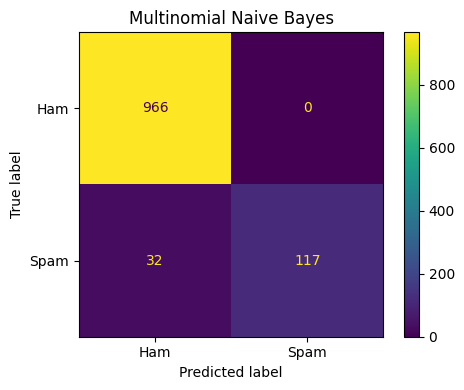

In [9]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
evaluate_model('Multinomial Naive Bayes', nb, X_test_tfidf, y_test);

### 4.2 Logistic Regression


Logistic Regression
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



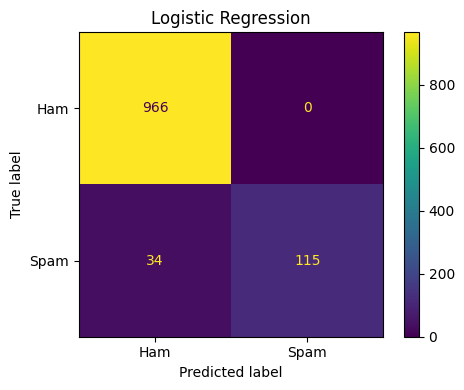

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
evaluate_model('Logistic Regression', lr, X_test_tfidf, y_test);

### 4.3 Support Vector Machine


Support Vector Machine
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



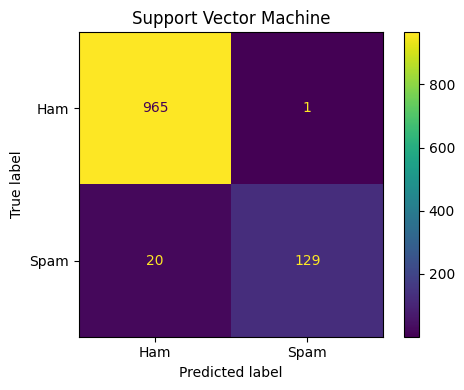

In [11]:
svm = LinearSVC(max_iter=2000)
svm.fit(X_train_tfidf, y_train)
evaluate_model('Support Vector Machine', svm, X_test_tfidf, y_test);

### 4.4 Character N-gram Logistic Regression


Character N-gram Logistic Regression
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.99      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



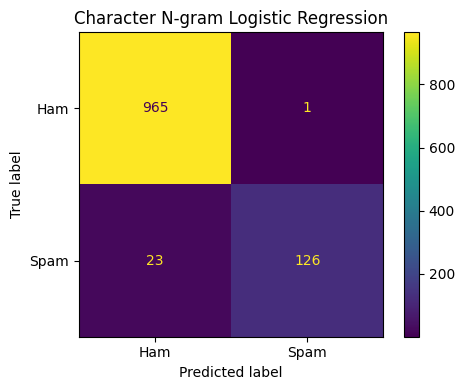

In [12]:
# Character-level TF-IDF with n-grams (3-5 chars)
char_tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=5000)
X_train_char = char_tfidf.fit_transform(X_train)
X_test_char = char_tfidf.transform(X_test)

lr_char = LogisticRegression(max_iter=1000)
lr_char.fit(X_train_char, y_train)
evaluate_model('Character N-gram Logistic Regression', lr_char, X_test_char, y_test);

## 5. Model Comparison

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

models = [
    ('Naive Bayes', nb, X_test_tfidf),
    ('Logistic Regression', lr, X_test_tfidf),
    ('SVM', svm, X_test_tfidf),
    ('Char N-gram LR', lr_char, X_test_char),
]

results = []
for name, model, X_vec in models:
    y_pred = model.predict(X_vec)
    results.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df.style.format('{:.3f}').highlight_max(axis=0)

,Precision,Recall,F1-Score
Model,,,
Naive Bayes,1.000,0.785,0.880
Logistic Regression,1.000,0.772,0.871
SVM,0.992,0.866,0.925
Char N-gram LR,0.992,0.846,0.913


## 6. Error Analysis

In [14]:
# Using best performing model (typically SVM or LR)
y_pred_best = svm.predict(X_test_tfidf)

# False Positives (ham predicted as spam)
fp_mask = (y_test == 0) & (y_pred_best == 1)
print("False Positives (Ham classified as Spam):")
print("-" * 50)
for msg in X_test[fp_mask].head(3):
    print(f"• {msg[:100]}..." if len(msg) > 100 else f"• {msg}")
    print()

False Positives (Ham classified as Spam):
--------------------------------------------------
• K..u also dont msg or reply to his msg..



In [15]:
# False Negatives (spam predicted as ham)
fn_mask = (y_test == 1) & (y_pred_best == 0)
print("False Negatives (Spam classified as Ham):")
print("-" * 50)
for msg in X_test[fn_mask].head(3):
    print(f"• {msg[:100]}..." if len(msg) > 100 else f"• {msg}")
    print()

False Negatives (Spam classified as Ham):
--------------------------------------------------
• Dear Voucher Holder 2 claim your 1st class airport lounge passes when using Your holiday voucher cal...

• Hi if ur lookin 4 saucy daytime fun wiv busty married woman Am free all next week Chat now 2 sort ti...

• ringtoneking 84484



## Summary

All four models perform well on this dataset. The class imbalance (87% ham, 13% spam) is handled effectively by the TF-IDF representation. Character n-grams capture patterns like URLs, phone numbers, and spam-specific text patterns that word-level features might miss.